# The equivalent observations method for GP model ensembles

This notebook illustrates how the concept of *equivalent observations*.

First, let's load some required packages

In [1]:
import numpy as np
import gpflow
import guepard
import matplotlib.pyplot as plt

from gpflow.utilities import print_summary
from guepard.gpr import get_gpr_submodels

from scipy.stats import multivariate_normal as mvn

# The lines below are specific to the notebook format
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 12

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 150em; }</style>"));


## Couple of helper functions for plotting

# Plot the model
def plot_mean_conf(x, mean, var, ax, color='C0', alpha=1.):
        ax.plot(x, mean, color, lw=2, alpha=alpha)
        ax.fill_between(
            x[:, 0],
            mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
            mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
            color=color,
            alpha=alpha * 0.2,
        )


def plot_model(m, ax, x=np.linspace(0, 1, 101)[:, None], plot_data=True, color='C0', alpha=1.):
    if plot_data:
        X, Y = m.data
        ax.plot(X, Y, "kx", mew=1.)
    
    mean, var = m.predict_f(x)[:2]
    plot_mean_conf(x, mean, var, ax, color, alpha)


def plt_mvn(mu, Sigma, color='C0', linestyles='solid'):
    x, y = np.meshgrid(np.linspace(-3.2, 2.5, 300),np.linspace(-2.5 ,8,300))
    xy = np.column_stack([x.flat, y.flat])

    # density values at the grid points
    Z = mvn.pdf(xy, mu.flatten(), Sigma).reshape(x.shape)

    # arbitrary contour levels
    fig = plt.contour(x, y, Z, colors=color, levels=3, linestyles=linestyles, label='label')
    mup, Sp = np.zeros((2, 1)), kernel.K(Xt).numpy()



/Users/nicolasdurrande/projects/guepard/.venv/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/Users/nicolasdurrande/projects/guepard/.venv/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


First, let us consider a simple dataset and fit a GP model to it

In [2]:
noise_var = 0.01

def f(x):
    return np.sin(10 * x[:, :1]) + 3. * x[:, :1]

X = np.linspace(0.3, 0.6, 30)[:, None]
Y = f(X) + np.sqrt(noise_var) * np.random.normal(size=X.shape)

# Define a GP model with GPflow
kernel = gpflow.kernels.Matern32()
m = gpflow.models.GPR((X, Y), kernel, noise_variance=noise_var)

/Users/nicolasdurrande/projects/guepard/.venv/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


Given $p$ prediction points $X^*$, the equivalent observation is defined as the vector $Y^*$ and the observation noise $\varepsilon^* \sim \mathcal{N}(0, T)$ such that the posterior distribution of $f(X_t)$ given the equivalent observations matches exactly the posterior of $f(X_t)$ given the full dataset. In other words, $Y^*$ and $\varepsilon^*$ are defined such that
$$f(X_t)|f(X_t)+\varepsilon^*=Y^* \quad = \quad f(X_t)|f(X)+\varepsilon=Y$$ 

On our example, we can pick $X^* = [-0.15, 1.15]$ 

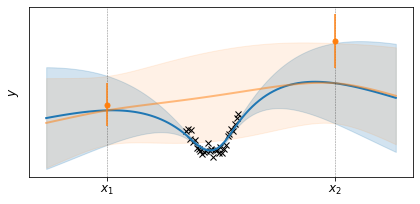

In [3]:
Xt = np.array([[-0.15, 1.15]]).T 
mup, Sp = np.zeros((2, 1)), kernel.K(Xt).numpy()

jitter = 1e-8 * np.eye(2)

# Compute the equivalent observations
me1, Se1 = m.predict_f(Xt, full_cov=True)
me1, Se1 = me1.numpy(), Se1.numpy()[0]
Spl1 = Sp @ np.linalg.inv(Sp - Se1 + jitter) @ Sp - Sp
Spl1 = np.linalg.inv(-np.linalg.inv(Sp) + np.linalg.inv(Se1) + jitter)   # This is T
mpl1 = mup + Sp @ np.linalg.inv(Sp - Se1 + jitter) @ (me1 - mup)         # This is Y^*

# posterior predictions given the equivalent observation
x = np.linspace(-.5, 1.5, 101)[:, None]
kx = kernel.K(x, Xt).numpy()
kxx = kernel.K(x).numpy()
mx = kx @ np.linalg.inv(Sp + Spl1) @ mpl1
vx = kxx - kx @ np.linalg.inv(Sp + Spl1) @ kx.T
vx = np.diag(vx)[:, None]

# plot predictions
fig, axes = plt.subplots(1, 1, figsize=(6, 3))
x = np.linspace(-.5, 1.5, 101)[:, None]
plt.plot(X, Y, 'kx', alpha=0.1)
plot_model(m, axes, x)
plot_mean_conf(x, mx, vx, axes, 'C1', alpha=.5)

[axes.axvline(x, color='k', linestyle="dashed", linewidth=.5, alpha=.5) for x in Xt]
[plt.plot(x, y, "C1o", ms=5.) for x, y in zip(Xt, mpl1)]
[plt.vlines(x, y-np.sqrt(c), y+np.sqrt(c) , "C1") for x, y, c in zip(Xt, mpl1, np.diag(Spl1))]
axes.set_xticks(Xt.flatten().tolist())
axes.set_yticks([])
axes.set_xticklabels(["$x_1$", "$x_2$"])
axes.set_ylabel("$y$")
plt.tight_layout()

plt.savefig("toy_implicit_obs.pdf")

Alternatively, one may choose to represent the equivalent observation as a likelihood function. With this point of view, the equivalent likelihood is function such that turns the prior distribution at test location into the posterior. It is thus given by the ratio posterior/prior.

/var/folders/hf/nx4hh6mj3bsfyxc4p3splhxr0000gn/T/ipykernel_21011/695380490.py:51: UserWarning: The following kwargs were not used by contour: 'label'
  fig = plt.contour(x, y, Z, colors=color, levels=3, linestyles=linestyles, label='label')


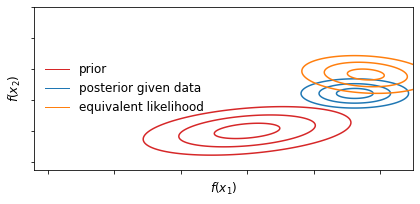

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
plt_mvn(mup, Sp, 'C3')
plt_mvn(me1, Se1, 'C0')
plt_mvn(mpl1, Spl1, 'C1')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='C3', lw=1),
                Line2D([0], [0], color='C0', lw=1),
                Line2D([0], [0], color='C1', lw=1)]

ax.legend(custom_lines, ['prior', 'posterior given data', 'equivalent likelihood'], loc="center left", frameon=False)
#ax.set_xticks([])
#ax.set_yticks([])
ax.set_xlabel("$f(x_1)$")
ax.set_ylabel("$f(x_2)$")
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
plt.tight_layout()

plt.savefig("toy_implicit_lik.pdf")

## Application to posterior predictions with a GPR ensemble



We build a larger dataset that we split in three, and build a GPR model for each of them

In [5]:
X = np.linspace(0, 1, 101)[:, None]
Y = f(X) + np.sqrt(noise_var) * np.random.normal(size=X.shape)

num_split = 3

Xl = np.array_split(X, num_split)  # list of num_split np.array
Yl = np.array_split(Y, num_split)  

kernel = gpflow.kernels.Matern32()

# make submodels and aggregate them
M = get_gpr_submodels(zip(Xl, Yl), kernel, noise_variance=noise_var) # list of num_split GPR models

m_agg = guepard.GprPapl(M)

`M` is a list of GPR models, let's plot them

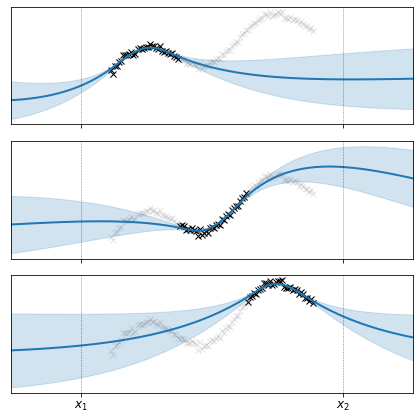

In [6]:
# plot predictions
x = np.linspace(-.5, 1.5, 101)[:, None]
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

for i, m in enumerate(M):    
    ax = axes[i]
    ax.plot(X, Y, 'kx', alpha=0.1)
    plot_model(m, ax, x, alpha=1.)
    ax.set_xlim([-.5, 1.5])
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    [ax.axvline(x, color='k', linestyle="dashed", linewidth=.5, alpha=.5) for x in Xt]
    ax.set_xticks(Xt.flatten().tolist())
    ax.set_xticklabels(["$x_1$", "$x_2$"])
    
#[axes[i].plot(X, Y, 'kx', mew=1., alpha=.1) for i, _ in enumerate(M)];
plt.tight_layout()
plt.savefig(f"toy_submodels.pdf")

We plot the prior, model 1 and the implitic observation at (x1, x2)

In [7]:
Xt = np.array([[-0.15, 1.15]]).T 
mup, Sp = np.zeros((2, 1)), kernel.K(Xt).numpy()

jitter = 1e-8 * np.eye(2)

me0, Se0 = M[0].predict_f(Xt, full_cov=True)
me0, Se0 = me0.numpy(), Se0.numpy()[0]
Spl0 = Sp @ np.linalg.inv(Sp - Se0 + jitter) @ Sp - Sp
Spl0 = np.linalg.inv(-np.linalg.inv(Sp) + np.linalg.inv(Se0) + jitter)
mpl0 = mup + Sp @ np.linalg.inv(Sp - Se0 + jitter) @ (me0 - mup)

me1, Se1 = M[1].predict_f(Xt, full_cov=True)
me1, Se1 = me1.numpy(), Se1.numpy()[0]
Spl1 = Sp @ np.linalg.inv(Sp - Se1 + jitter) @ Sp - Sp
Spl1 = np.linalg.inv(-np.linalg.inv(Sp) + np.linalg.inv(Se1) + jitter)
mpl1 = mup + Sp @ np.linalg.inv(Sp - Se1 + jitter) @ (me1 - mup)

me2, Se2 = M[2].predict_f(Xt, full_cov=True)
me2, Se2 = me2.numpy(), Se2.numpy()[0]
Spl2 = Sp @ np.linalg.inv(Sp - Se2 + jitter) @ Sp - Sp
Spl2 = np.linalg.inv(-np.linalg.inv(Sp) + np.linalg.inv(Se2) + jitter)
mpl2 = mup + Sp @ np.linalg.inv(Sp - Se2 + jitter) @ (me2 - mup)

(2, 1) (2, 2)


/var/folders/hf/nx4hh6mj3bsfyxc4p3splhxr0000gn/T/ipykernel_21011/695380490.py:51: UserWarning: The following kwargs were not used by contour: 'label'
  fig = plt.contour(x, y, Z, colors=color, levels=3, linestyles=linestyles, label='label')


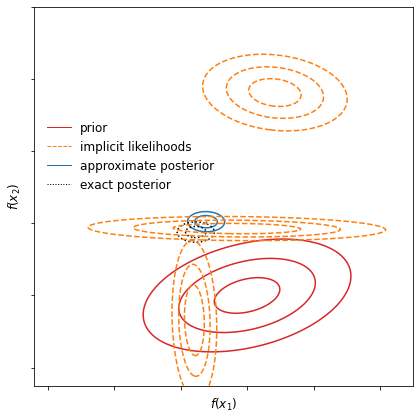

In [8]:
m_gpr = gpflow.models.GPR((X, Y), kernel, noise_variance=noise_var)
m_agg = guepard.GprPapl(M)

mean_papl, var_papl = m_agg.predict_f(Xt, full_cov=True)
mean_papl, var_papl = mean_papl.numpy(), var_papl.numpy()[0]
mean_gpr, var_gpr = m_gpr.predict_f(Xt, full_cov=True)
mean_gpr, var_gpr = mean_gpr.numpy(), var_gpr.numpy()[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
print(mean_gpr.shape, var_gpr.shape)
plt_mvn(mup, Sp, 'C3')
plt_mvn(mean_papl, var_papl, 'C0')
plt_mvn(mean_gpr, var_gpr, 'k', linestyles='dotted')
plt_mvn(mpl0, Spl0, 'C1', linestyles='dashed')
plt_mvn(mpl1, Spl1, 'C1', linestyles='dashed')
plt_mvn(mpl2, Spl2, 'C1', linestyles='dashed')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='C3', lw=1),
                Line2D([0], [0], color='C1', linestyle="dashed", lw=1),
                Line2D([0], [0], color='C0', lw=1),
                Line2D([0], [0], color='k', linestyle="dotted", lw=1)]

ax.legend(custom_lines, ['prior', 'implicit likelihoods', 'approximate posterior', 'exact posterior'], loc=(0.02, .5), frameon=False)

ax.set_xlabel("$f(x_1)$")
ax.set_ylabel("$f(x_2)$")
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
plt.tight_layout()
plt.savefig("toy_approx_posterior.pdf")
